In [1]:
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import json
import seaborn as sns
import matplotlib

In [2]:
def load_proteins(diseases):
    diseases = ['colorectal_adenocarcinoma', 'diffuse_large_b-cell_lymphoma', 'melanoma']

    proteins = dict()
    for disease in diseases:
        df = pd.read_csv(f'../results/test_results/{disease}/{disease}_fpr_0.05_prediction_results.tsv', sep='\t')
        proteins[disease] = df['protein'].to_list()
        
    # get the proteins section for a venn diagram
    union_section = set(itertools.chain.from_iterable([proteins[disease] for disease in diseases]))
    core_section = set(proteins[diseases[0]])
    for disease in diseases[1:]:
        core_section = core_section.intersection(set(proteins[disease]))

    unique_section = dict()
    for disease in diseases:
        # proteins only in this disease
        unique_proteins = set(proteins[disease]) 
        other_proteins = set(itertools.chain.from_iterable([proteins[other_disease] for other_disease in diseases if other_disease != disease]))
        unique_proteins = unique_proteins - other_proteins
        unique_section[disease] = unique_proteins

    # unique intersection of two diseases
    intersection_section = dict()
    for disease1, disease2 in combinations(diseases, 2):
        intersection_proteins = set(proteins[disease1]).intersection(set(proteins[disease2]))
        other_proteins = set(itertools.chain.from_iterable([proteins[other_disease] for other_disease in diseases if other_disease not in [disease1, disease2]]))
        intersection_proteins = intersection_proteins - other_proteins
        intersection_section[f'{disease1} & {disease2}'] = intersection_proteins

    # print the size of each section
    print(f'Core section: {len(core_section)}')
    for disease in diseases:
        print(f'Unique section for {disease}: {len(unique_section[disease])}')
    for disease1, disease2 in combinations(diseases, 2):
        print(f'Intersection section for {disease1} & {disease2}: {len(intersection_section[f"{disease1} & {disease2}"])}')
        
    # put all sections into a dictionary
    sections = {
        'core': core_section,
        'unique': unique_section,
        'intersection': intersection_section,
        'union': union_section
    }
    return sections


def jaccard_index(set1, set2):
    set1 = set(set1)
    set2 = set(set2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0.0
    return round(intersection / union, 2)

def calculate_strength(observed, network_size, term_frequency, total_proteins=19699):
    """
    Calculate the strength (log10 of observed/expected ratio) for functional enrichment.
    
    Parameters:
    observed (int): Number of proteins in your network annotated with the term
    network_size (int): Total number of proteins in your network/dataset
    term_frequency (int): Total number of proteins annotated with this term in the background
    total_proteins (int): Total number of proteins in the background database (default: 20000)
    
    Returns:
    float: Strength score (log10 of observed/expected ratio)
    """
    # Calculate expected number of proteins with this term in a random network
    expected = (network_size * term_frequency) / total_proteins
    
    # Avoid division by zero
    if expected == 0:
        return float('inf') if observed > 0 else 0
    
    # Calculate strength as log10(observed/expected)
    ratio = observed / expected
    # return f'{ratio:.2e}'
    # strength = math.log10(ratio)
    
    return ratio

def enrichment_with_background(genes, background,union_size):

    string_api_url = "https://version-12-0.string-db.org/api"
    output_format = "json"
    method = "enrichment"


    request_url = "/".join([string_api_url, output_format, method])


    params = {
        "identifiers" : "%0d".join(genes), # your protein
        "background_string_identifiers" : "%0d".join(background), # background proteins
        "species" : 9606, # NCBI/STRING taxon identifier 
        "caller_identity" : "net2rank" # your app name,
    }

    response = requests.post(request_url, data=params)

    data = json.loads(response.text)
    results = []

    for row in data:

        term = row["term"]
        fdr = float(row["fdr"])
        category = row["category"]
        
        strength = calculate_strength(
                    observed=row["number_of_genes"],
                    network_size=len(genes),
                    term_frequency=row["number_of_genes_in_background"],
                    total_proteins=union_size)
        strength = round(strength, 2)

        # if category == "Process" and fdr < 0.01:
        if fdr < 0.01:
            results.append({
                "term": term,
                "description": row["description"],
                "category": category,
                "fdr": fdr,
                'strength': strength,
                "p_value": row["p_value"],
                "inputGenes": row["inputGenes"],
                "number_of_genes": row["number_of_genes"],
                "number_of_genes_in_background": row["number_of_genes_in_background"],
            })
    return pd.DataFrame(results)
  

In [3]:
def enrichment_analysis(diseases, sections):
    """
    Perform enrichment analysis for the given diseases and proteins.
    
    Parameters:
    diseases (list): List of disease names.
    sections (dict): Dictionary containing core, unique, intersection, and union sections.

    Returns:
    pd.DataFrame: DataFrame containing enrichment results for each disease/section.
    """
    cancer_enrichment = list()

    for disease in diseases:
        print(f'Enrichment for {disease}')
        df = enrichment_with_background(
            genes=sections['unique'][disease],
            background=sections['union'],
            union_size=len(sections['union'])
        )
        df['disease'] = disease
        cancer_enrichment.append(df)

    for disease1, disease2 in combinations(diseases, 2):
        print(f'Enrichment for {disease1} & {disease2}')
        df = enrichment_with_background(
            genes=sections['intersection'][f'{disease1} & {disease2}'],
            background=sections['union'],
            union_size=len(sections['union'])
        )
        df['disease'] = f'{disease1} & {disease2}'
        cancer_enrichment.append(df)

    # core section enrichment
    print('Enrichment for core section')
    df_core = enrichment_with_background(
        genes=sections['core'],
        background=sections['union'],
        union_size=len(sections['union'])
    )
    df_core['disease'] = 'core'

    cancer_enrichment.append(df_core)

    cancer_enrichment = pd.concat(cancer_enrichment, ignore_index=True)
    cancer_enrichment['neg_log10_fdr'] = -np.log10(cancer_enrichment['fdr'])
    print('DONE.')

    return cancer_enrichment

In [4]:
def go_term_heatmap(enrichment: pd.DataFrame, go_terms: list):
    df_analysis = enrichment.copy()
    
        # calculate the Jaccard index for two sets of genes
    df_jaccard = list()
    for (idx1,row1) in df_analysis[df_analysis['term'].isin(go_terms)].iterrows():
        for (idx2,row2) in df_analysis[df_analysis['term'].isin(go_terms)].iterrows():
            # break
            set1 = row1['inputGenes']
            set2 = row2['inputGenes']
            jaccard_value = jaccard_index(set1, set2)
            
            if row1['term'] == row2['term'] and row1['disease'] == row2['disease']:
                jaccard_value = 0
            
            df_jaccard.append({
                'term1': f"{row1['description']} ({row1['term']})",
                'fdr1': row1['fdr'],
                'strength1': row1['strength'],
                'term2': f"{row2['description']} ({row2['term']})",
                'fdr2': row2['fdr'],
                'strength2': row2['strength'],
                'disease1': row1['disease'],
                'disease2': row2['disease'],
                'jaccard_index': jaccard_value
            })
    df_jaccard = pd.DataFrame(df_jaccard)
    
    df_jaccard = pd.DataFrame(df_jaccard)
    df_jaccard_pivot = df_jaccard.pivot_table(index='term1', columns='term2', values='jaccard_index', fill_value=0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(df_jaccard_pivot, 
                cmap='Oranges', 
                cbar_kws={'label': 'Jaccard Index'},
                vmin=0,
                vmax=1,
                linewidths=0.5,  # This adds cell lines
                linecolor='white')  # Color of the lines

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title('Jaccard Index Heatmap')
    plt.tight_layout()
    plt.show()
    

def make_bubble_plot(enrichment, 
                     go_terms,
                     log_fdr_cap=9,
                     base_dot_size=20,):
    
    def format_power_unicode(base, exponent):
        superscript_map = {
            '0': '⁰', '1': '¹', '2': '²', '3': '³', '4': '⁴',
            '5': '⁵', '6': '⁶', '7': '⁷', '8': '⁸', '9': '⁹',
            '-': '⁻', '.': '·'
        }
        exp_str = str(int(exponent) if exponent == int(exponent) else exponent)
        superscript = ''.join(superscript_map.get(char, char) for char in exp_str)
        return f'{base}{superscript}'
    
    diseases_order = ['core',
                  'melanoma',
                  'diffuse_large_b-cell_lymphoma',
                  'diffuse_large_b-cell_lymphoma & melanoma',
                  'colorectal_adenocarcinoma & melanoma',
                  'colorectal_adenocarcinoma',
                  'colorectal_adenocarcinoma & diffuse_large_b-cell_lymphoma',
                  ]

    df_make_plot = enrichment[enrichment['term'].isin(go_terms)].copy()
    df_make_plot['neg_log_fdr_cap'] = df_make_plot['neg_log10_fdr'].clip(upper=log_fdr_cap)
    
    descriptions = dict(zip(df_make_plot['term'], df_make_plot['description']))
    
    # order the descriptions by the order of the go_terms
    descriptions = {term: descriptions[term] for term in go_terms[::-1] if term in descriptions}
    disease_positions = {disease: i for i, disease in enumerate(diseases_order)}
    x_positions = df_make_plot['disease'].map(disease_positions)
    y_positions = {v: i for i, v in enumerate(descriptions.values())}
    
    


    fig, ax = plt.subplots(figsize=(7, 6))
    
    # background color for every second row
    for i in range(len(descriptions)):
        if i % 2 == 0:  # Every other row (0, 2, 4, 6...)
            ax.axhspan(i - 0.4, i + 0.4, 
                       alpha=0.1, color='grey', zorder=0)
    
    
    # plot the bubbles
    # norm=plt.Normalize(0,0.9)
    
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","darkblue","red"])
    scatter = ax.scatter(x_positions,
                     df_make_plot['description'].map(y_positions),
                     s=df_make_plot['neg_log_fdr_cap'] * base_dot_size,
                     c=df_make_plot['strength'],
                     cmap=cmap,
                     alpha=1,
                     edgecolors='w',
                     linewidth=0.5,
                     zorder=3,
                     vmin=1
                    #  norm=norm
                     )
    
    # Set custom axis labels and ticks
    ax.set_xticks(range(len(diseases_order)))
    ax.set_xticklabels(diseases_order)
    ax.set_yticks(range(len(descriptions)))
    ax.set_yticklabels(descriptions.values(),fontsize=11)
    
    # Customize ticks and grid
    ax.tick_params(axis='both', which='both', left=False, bottom=False, 
                top=False, right=False, color='lightgrey', labelsize=11)
    
    # Style tick labels
    for label in ax.get_xticklabels():
        label.set_fontweight('medium')
    for label in ax.get_yticklabels():
        label.set_fontweight('medium')

    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Create size legend
    legend_values = np.linspace(3, 9, 3)

    legend_elements = [plt.scatter([], [], s=val * base_dot_size, 
                                c='white', alpha=1, 
                                edgecolors='black', linewidth=0.5,
                                label=format_power_unicode('10', -val)) 
                    for val in legend_values]

    size_legend = ax.legend(handles=legend_elements, 
                        title='FDR', 
                        loc='center left', 
                        bbox_to_anchor=(1, 0.5),
                        frameon=False,
                        title_fontsize=10,
                        fontsize=10,
                        handletextpad=1.2,
                        labelspacing=1.2)
    ax.add_artist(size_legend)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.15)
    cbar.set_label('Observed/Expected', labelpad=15, fontsize=11)
    cbar.ax.yaxis.set_label_position('left')
    cbar.ax.set_position([1.5, 0.5, 0.2, 0.35])

    # Hide x-axis
    ax.xaxis.set_visible(False)

    # Save and show
    plt.tight_layout()
    plt.savefig('bubble_plot.png', bbox_inches='tight', dpi=300)
    plt.show()
    

## processing

In [5]:
diseases = ['colorectal_adenocarcinoma', 'diffuse_large_b-cell_lymphoma', 'melanoma']
sections = load_proteins(diseases)
# enrichment = enrichment_analysis(diseases, sections)
for section_name, section_proteins in sections.items():
    # 
    if type(section_proteins) is dict:
        for sub_section_name, sub_section_proteins in section_proteins.items():
            with open(f'temp/{sub_section_name}.txt', 'w') as f:
                f.write('\n'.join(sub_section_proteins))
    else:
        with open(f'temp/{section_name}.txt', 'w') as f:
            f.write('\n'.join(section_proteins))

Core section: 1388
Unique section for colorectal_adenocarcinoma: 273
Unique section for diffuse_large_b-cell_lymphoma: 936
Unique section for melanoma: 955
Intersection section for colorectal_adenocarcinoma & diffuse_large_b-cell_lymphoma: 217
Intersection section for colorectal_adenocarcinoma & melanoma: 335
Intersection section for diffuse_large_b-cell_lymphoma & melanoma: 642


In [6]:
cancer_enrichment = enrichment_analysis(diseases, sections)

Enrichment for colorectal_adenocarcinoma
Enrichment for diffuse_large_b-cell_lymphoma
Enrichment for melanoma
Enrichment for colorectal_adenocarcinoma & diffuse_large_b-cell_lymphoma
Enrichment for colorectal_adenocarcinoma & melanoma
Enrichment for diffuse_large_b-cell_lymphoma & melanoma
Enrichment for core section
DONE.


In [ ]:
cancer_enrichment.to_csv('results/cancers_upset_enrichment.tsv',sep='\t')

In [7]:
cancer_enrichment

,term,description,category,fdr,strength,p_value,inputGenes,number_of_genes,number_of_genes_in_background,disease,neg_log10_fdr
0,GO:0070647,Protein modification by small protein conjugat...,Process,1.740000e-07,2.99,1.870000e-11,"[9606.ENSP00000218348, 9606.ENSP00000219689, 9...",51,297,colorectal_adenocarcinoma,6.759451
1,GO:0016579,Protein deubiquitination,Process,8.130000e-07,6.76,1.930000e-10,"[9606.ENSP00000218348, 9606.ENSP00000219689, 9...",21,54,colorectal_adenocarcinoma,6.089909
2,GO:0070646,Protein modification by small protein removal,Process,8.130000e-07,6.37,1.750000e-10,"[9606.ENSP00000218348, 9606.ENSP00000219689, 9...",22,60,colorectal_adenocarcinoma,6.089909
3,GO:0006508,Proteolysis,Process,1.470000e-05,2.58,6.340000e-09,"[9606.ENSP00000218348, 9606.ENSP00000219689, 9...",48,323,colorectal_adenocarcinoma,4.832683
4,GO:0006511,Ubiquitin-dependent protein catabolic process,Process,1.920000e-05,3.25,1.030000e-08,"[9606.ENSP00000218348, 9606.ENSP00000219689, 9...",34,182,colorectal_adenocarcinoma,4.716699
...,...,...,...,...,...,...,...,...,...,...,...
3274,CL:17470,"GPVI-mediated activation cascade, and SH2 doma...",NetworkNeighborAL,2.300000e-03,2.48,1.040000e-05,"[9606.ENSP00000216373, 9606.ENSP00000222254, 9...",42,58,core,2.638272
3275,CL:17673,"Mixed, incl. Inhibition of exosome biogenesis ...",NetworkNeighborAL,2.600000e-03,3.42,1.310000e-05,"[9606.ENSP00000215832, 9606.ENSP00000246792, 9...",26,26,core,2.585027
3276,CL:6897,"Mixed, incl. G1 Phase, and G0 and Early G1",NetworkNeighborAL,3.000000e-03,2.52,1.660000e-05,"[9606.ENSP00000227507, 9606.ENSP00000228872, 9...",39,53,core,2.522879
3277,CL:17668,"Mixed, incl. Signalling to ERKs, and Ras GTPas...",NetworkNeighborAL,3.500000e-03,2.70,2.040000e-05,"[9606.ENSP00000215832, 9606.ENSP00000246792, 9...",34,43,core,2.455932


In [13]:
with open('core.txt', 'w') as f:
    for protein in sections['core']:
        f.write(f"{protein}\n")

In [14]:
with open('union.txt', 'w') as f:
    for protein in sections['union']:
        f.write(f"{protein}\n")

## bubble plot

/var/folders/92/7gry22qd3jj0_455yl6whqm40000gn/T/ipykernel_44495/235024700.py:163: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


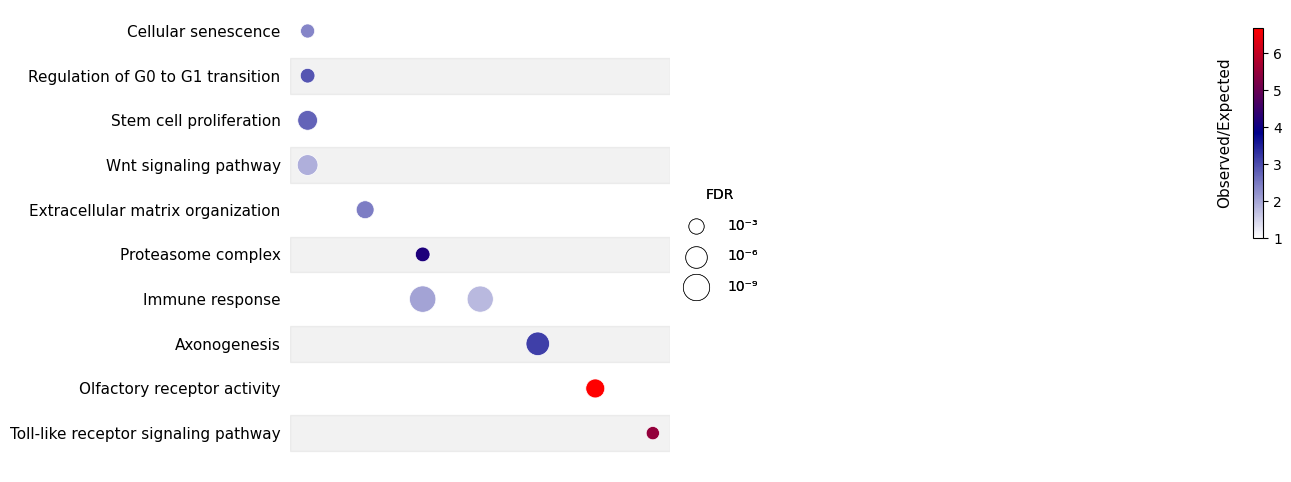

In [ ]:

selected_go_terms = [
    'GO:0090398', # cell senescence
    'GO:0070316', # g0 to g1 transition
    'GO:0072089', # stem cell proliferation
    'GO:0016055', # Wnt signaling pathway
    
    'GO:0030198', # extracellular matrix organization

    'GO:0000502', # proteasome complex
    'GO:0006955', # immune response

    'GO:0007409', # axonogenesis
    # 
    'GO:0004984', # olfactory receptor activity

    'GO:0002224', # toll-like receptor signaling pathway
]

make_bubble_plot(cancer_enrichment, selected_go_terms, log_fdr_cap=9, base_dot_size=40)

In [9]:
from upsetplot import UpSet,from_memberships

def make_upset_plot(upset_data):
    fig = plt.figure(figsize=(12, 6))  # Increase width to accommodate right bars

    upset = UpSet(upset_data, 
                show_counts=True, 
                sort_by='cardinality',
                element_size=50,)
    upset.plot(fig=fig)

    # Get axes
    ax_intersections = fig.axes[-1]  # Top bars (intersection sizes)
    ax_matrix = fig.axes[1]         # Dot matrix
    ax_totals = fig.axes[2]         # Left bars (set sizes)
    ax_intersections.set_yticks([])  # Add this line
    # Your manual total counts (adjust these as needed)
    actual_totals = [2213, 3183, 3320]  # Top to bottom order

    # Keep the original labels on the left, but hide the bars
    for bar in ax_totals.patches:
        bar.set_visible(False)  # Hide the bars but keep the labels

    # Remove the left axis spines and ticks
    ax_totals.spines['top'].set_visible(False)
    ax_totals.spines['right'].set_visible(False)
    ax_totals.spines['bottom'].set_visible(False)
    ax_totals.spines['left'].set_visible(False)
    ax_totals.set_xticks([])  # Remove x-axis ticks
    ax_totals.tick_params(left=False,labelsize=10)  # Remove y-axis ticks

    # Get matrix position to align the right bars
    matrix_pos = ax_matrix.get_position()

    # Create new right axis for totals - same height and y-position as matrix
    ax_right = fig.add_axes([matrix_pos.x1 + 0.02, matrix_pos.y0, 0.15, matrix_pos.height])

    # Create horizontal bars with manual data
    bars = ax_right.barh(range(len(actual_totals)), actual_totals, color='#1A1628')

    # Set up the right axis - NO labels, just the bars and values
    ax_right.set_yticks([])  # No y-tick labels
    ax_right.set_xlabel('Set size')
    ax_right.invert_yaxis()  # Match the matrix row order

    # Remove box/spines around the right bars
    ax_right.spines['top'].set_visible(False)
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['left'].set_visible(False)

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, actual_totals)):
        ax_right.text(bar.get_width() + max(actual_totals)*0.01, bar.get_y() + bar.get_height()/2, 
                    str(int(value)), ha='left', va='center', fontsize=10)

    # Color the intersection bars
    intersection_bar_width = 0.66  # Control intersection bar width
    for i, bar in enumerate(ax_intersections.patches):
        bar.set_facecolor('#1A1628')
        # Get current bar properties
        x = bar.get_x()
        
        # Calculate new width and x position to center the bar
        current_width = bar.get_width()
        new_width = intersection_bar_width
        new_x = x + (current_width - new_width) / 2
        
        # Set new properties
        bar.set_width(new_width)
        bar.set_x(new_x)

    # Color the dots
    default_dot_color = '#A3A1A8'     
    active_dot_color = '#1A1628' 
    for collection in ax_matrix.collections:
        colors = collection.get_facecolors()
        new_colors = []
        for color in colors:
            if len(color) > 3 and color[3] > 0.5:  
                new_colors.append(active_dot_color)  
            else:
                new_colors.append(default_dot_color)  
        
        collection.set_facecolors(new_colors)

    plt.savefig("upset_plot.png", bbox_inches='tight', dpi=300)
    plt.show()

/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/pst325/Documents/zs_work/net2rank/.venv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original

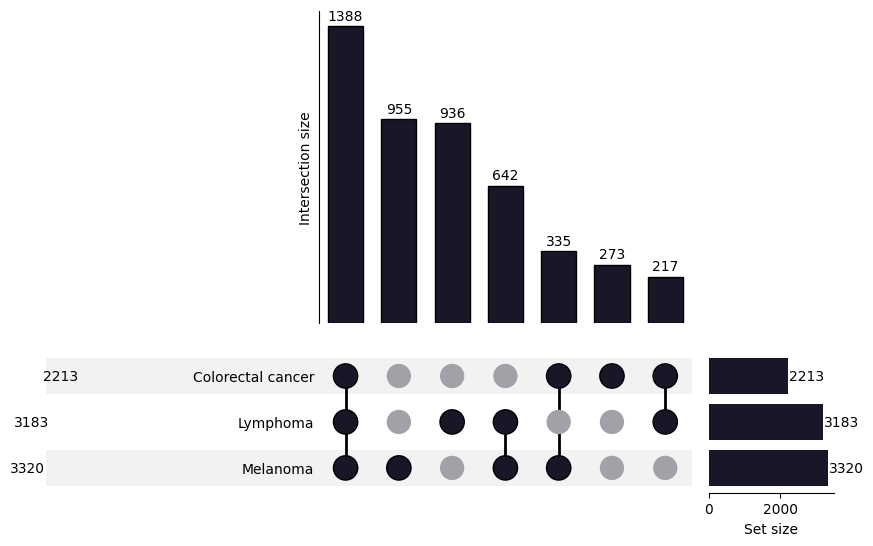

In [10]:
upset_data = from_memberships(
    [
        ['Colorectal cancer'],

        # Only in diffuse large B-cell lymphoma (936)
        ['Lymphoma'],

        # Only in melanoma (955)
        ['Melanoma'],

        # colorectal adenocarcinoma + diffuse large B-cell lymphoma only (217)
        ['Colorectal cancer', 'Lymphoma'],

        # colorectal adenocarcinoma + melanoma only (335)
        ['Colorectal cancer', 'Melanoma'],

        # diffuse large B-cell lymphoma + melanoma only (642)
        ['Lymphoma', 'Melanoma'],

        # All three intersect (1388)
        ['Colorectal cancer', 'Lymphoma', 'Melanoma'],
    ],
    data=[273, 936, 955, 217, 335, 642, 1388]
)
make_upset_plot(upset_data)